# Distributed training of ATLAS RPV CNN Classifier

In this notebook, we extend the Train_rpv example to train distributed across nodes
using ipyparallel and Horovod.

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

# External imports
import ipyparallel as ipp

import matplotlib.pyplot as plt
%matplotlib notebook

## Connect to ipyparallel cluster

In [2]:
%%bash
squeue -u sfarrell

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13956747 interacti       sh sfarrell  R      42:09      8 nid000[88-95]


In [3]:
# Cluster ID taken from job ID above
job_id = 13956747
cluster_id = 'cori_{}'.format(job_id)

# Use default profile
c = ipp.Client(timeout=60, cluster_id=cluster_id)
print('Worker IDs:', c.ids)

Worker IDs: [0, 1, 2, 3, 4, 5, 6, 7]


## Setup the workers

In [4]:
%%px

from __future__ import print_function
from __future__ import division

import os
import socket

import keras
import horovod.keras as hvd

from rpv import load_dataset, build_model, train_model

[stderr:0] 
/global/common/software/dasrepo/JupyterDL/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[stderr:1] 
/global/common/software/dasrepo/JupyterDL/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[stderr:2] 
/global/common/software/dasrepo/JupyterDL/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float6

In [5]:
%%px

# Initialize horovod
hvd.init()
print('MPI rank %i, local rank %i, host %s' %
      (hvd.rank(), hvd.local_rank(), socket.gethostname()))

[stdout:0] MPI rank 0, local rank 0, host nid00088
[stdout:1] MPI rank 2, local rank 0, host nid00090
[stdout:2] MPI rank 1, local rank 0, host nid00089
[stdout:3] MPI rank 3, local rank 0, host nid00091
[stdout:4] MPI rank 7, local rank 0, host nid00095
[stdout:5] MPI rank 6, local rank 0, host nid00094
[stdout:6] MPI rank 4, local rank 0, host nid00092
[stdout:7] MPI rank 5, local rank 0, host nid00093


## Load the data

In [6]:
%%px

# Data config
n_train = 64000 #412416
n_valid = 32000 #137471
n_test = 32000 #137471
input_dir = '/global/cscratch1/sd/sfarrell/atlas-rpv-images'

# Load the data files
((train_input, train_labels, train_weights),
 (valid_input, valid_labels, valid_weights),
 (test_input, test_labels, test_weights)) = load_dataset(input_dir, n_train, n_valid, n_test)
print('train shape:', train_input.shape)
print('valid shape:', valid_input.shape)
print('test shape: ', test_input.shape)

[stdout:0] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)
[stdout:1] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)
[stdout:2] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)
[stdout:3] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)
[stdout:4] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)
[stdout:5] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)
[stdout:6] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)
[stdout:7] 
train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)


## Build and train the model

In [9]:
%%px

# Model config
conv_sizes = [16, 32, 64]
fc_sizes = [128]
optimizer = 'Adam'
lr = 0.001 * hvd.size()
dropout=0.2

# Training config
batch_size = 128
n_epochs = 4

# Build the model
model = build_model(train_input.shape[1:],
                    conv_sizes=conv_sizes, fc_sizes=fc_sizes,
                    dropout=dropout,
                    optimizer=optimizer, lr=lr,
                    use_horovod=True)
if hvd.rank() == 0:
    model.summary()

[stdout:0] 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0        

In [10]:
%%px

# Train the model
history = train_model(model, train_input=train_input, train_labels=train_labels,
                      valid_input=valid_input, valid_labels=valid_labels,
                      batch_size=batch_size, n_epochs=n_epochs,
                      use_horovod=True)

[stdout:0] 
Train on 64000 samples, validate on 32000 samples
Epoch 1/4
 - 31s - loss: 0.2363 - acc: 0.9068 - val_loss: 0.1882 - val_acc: 0.9268
Epoch 2/4
 - 30s - loss: 0.0518 - acc: 0.9812 - val_loss: 0.0598 - val_acc: 0.9805
Epoch 3/4
 - 31s - loss: 0.0226 - acc: 0.9922 - val_loss: 0.0464 - val_acc: 0.9860
Epoch 4/4
 - 30s - loss: 0.0157 - acc: 0.9944 - val_loss: 0.0548 - val_acc: 0.9862
[stdout:1] 
Train on 64000 samples, validate on 32000 samples
Epoch 1/4
 - 31s - loss: 0.2369 - acc: 0.9056 - val_loss: 0.1882 - val_acc: 0.9268
Epoch 2/4
 - 30s - loss: 0.0513 - acc: 0.9817 - val_loss: 0.0598 - val_acc: 0.9805
Epoch 3/4
 - 30s - loss: 0.0223 - acc: 0.9922 - val_loss: 0.0464 - val_acc: 0.9860
Epoch 4/4
 - 30s - loss: 0.0149 - acc: 0.9950 - val_loss: 0.0548 - val_acc: 0.9862
[stdout:2] 
Train on 64000 samples, validate on 32000 samples
Epoch 1/4
 - 31s - loss: 0.2381 - acc: 0.9050 - val_loss: 0.1882 - val_acc: 0.9268
Epoch 2/4
 - 30s - loss: 0.0515 - acc: 0.9814 - val_loss: 0.0598 - 

In [11]:
# Can I get worker-local variables out?
epochs = c[0].get('history.epoch')
histories = c[:].get('history.history')

In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


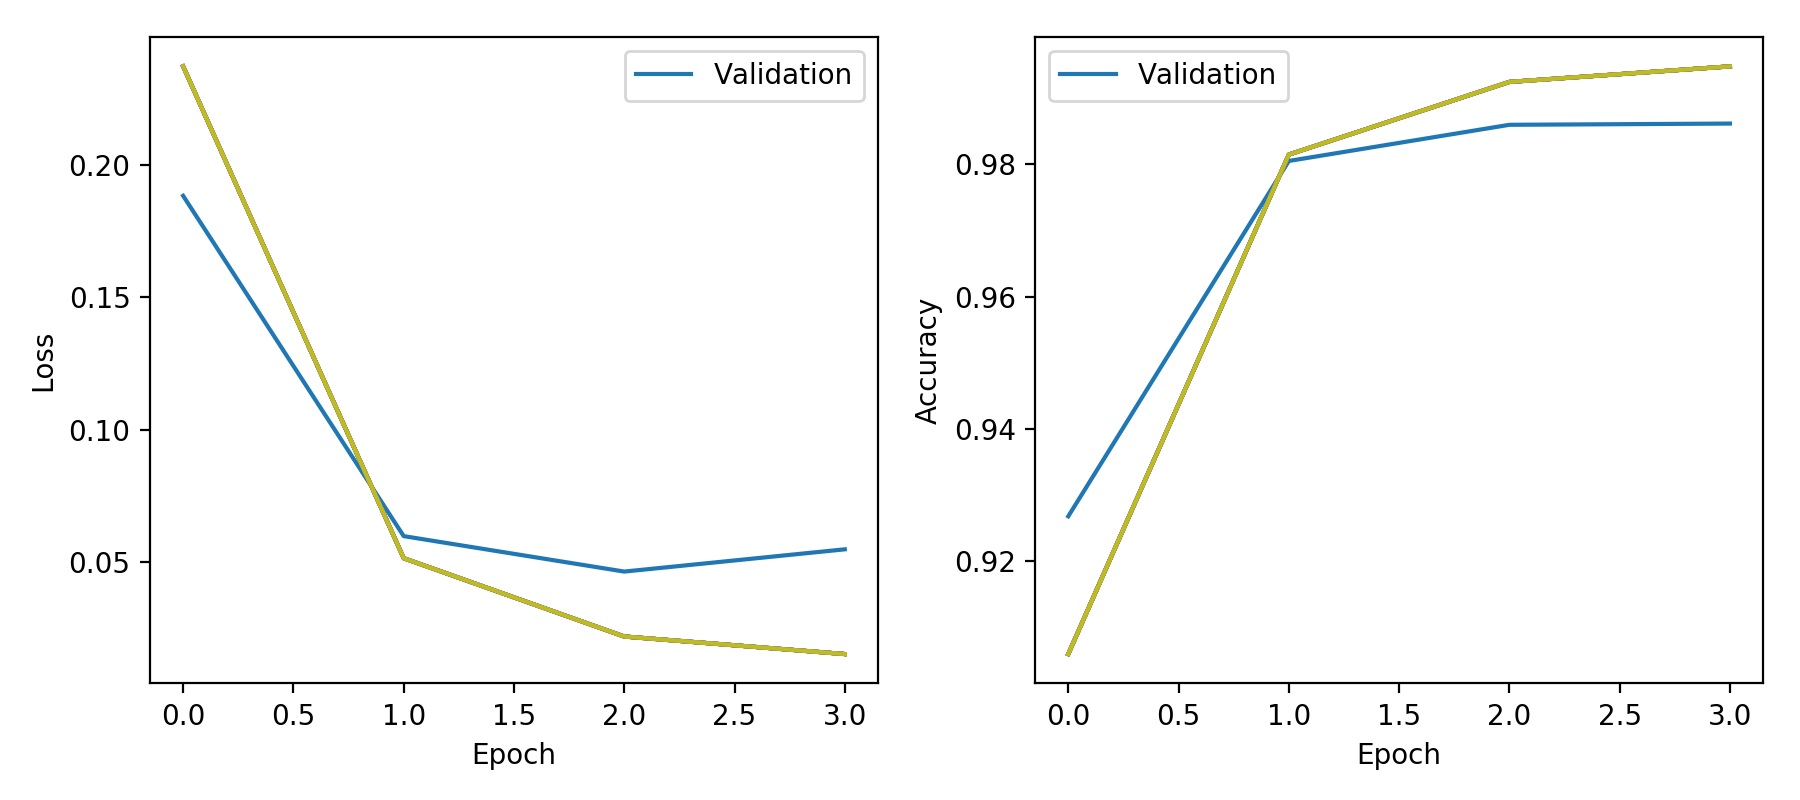

In [13]:
plt.figure(figsize=(9,4))

# Plot the loss
plt.subplot(121)
plt.plot(epochs, histories[0]['val_loss'], label='Validation')
for i, h in enumerate(histories):
    plt.plot(epochs, h['loss'])#, label='Train %i' % i)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Plot the accuracy
plt.subplot(122)
plt.plot(epochs, histories[0]['val_acc'], label='Validation')
for i, h in enumerate(histories):
    plt.plot(epochs, h['acc'])#, label='Train %i' % i)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

## Evaluate on the test set

In [14]:
from sklearn import metrics

def summarize_metrics(labels, outputs, threshold=0.5, weights=None):
    preds = outputs > threshold
    #print('Metrics summaries with threshold of %.3f' % threshold)
    print('Accuracy:   %.4f' % metrics.accuracy_score(labels, preds, sample_weight=weights))
    print('Purity:     %.4f' % metrics.precision_score(labels, preds, sample_weight=weights))
    print('Efficiency: %.4f' % metrics.recall_score(labels, preds, sample_weight=weights))

def draw_roc(labels, outputs, weights=None, ax=None):
    fpr, tpr, _ = metrics.roc_curve(labels, outputs, sample_weight=weights)
    auc = metrics.roc_auc_score(labels, outputs, sample_weight=weights)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='CNN, AUC=%.3f' % auc)
    ax.plot([0, 1], [0, 1], '--', label='Random')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc=0)

In [15]:
%%px

test_output = model.predict(test_input)
test_output = test_output.squeeze(-1)
score = model.evaluate(test_input, test_labels, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[stdout:0] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575
[stdout:1] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575
[stdout:2] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575
[stdout:3] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575
[stdout:4] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575
[stdout:5] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575
[stdout:6] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575
[stdout:7] 
Test loss: 0.05629645342000822
Test accuracy: 0.98575


In [16]:
test_output = c[0].get('test_output')
test_labels = c[0].get('test_labels')
test_weights = c[0].get('test_weights')

In [17]:
# Unweighted results
print('Unweighted metrics')
summarize_metrics(test_labels, test_output)
print()

# Weighted results
print('Weighted metrics')
summarize_metrics(test_labels, test_output, weights=test_weights)

Unweighted metrics
Accuracy:   0.9858
Purity:     0.9777
Efficiency: 0.9892

Weighted metrics
Accuracy:   0.8994
Purity:     0.0006
Efficiency: 0.9892


<IPython.core.display.Javascript object>


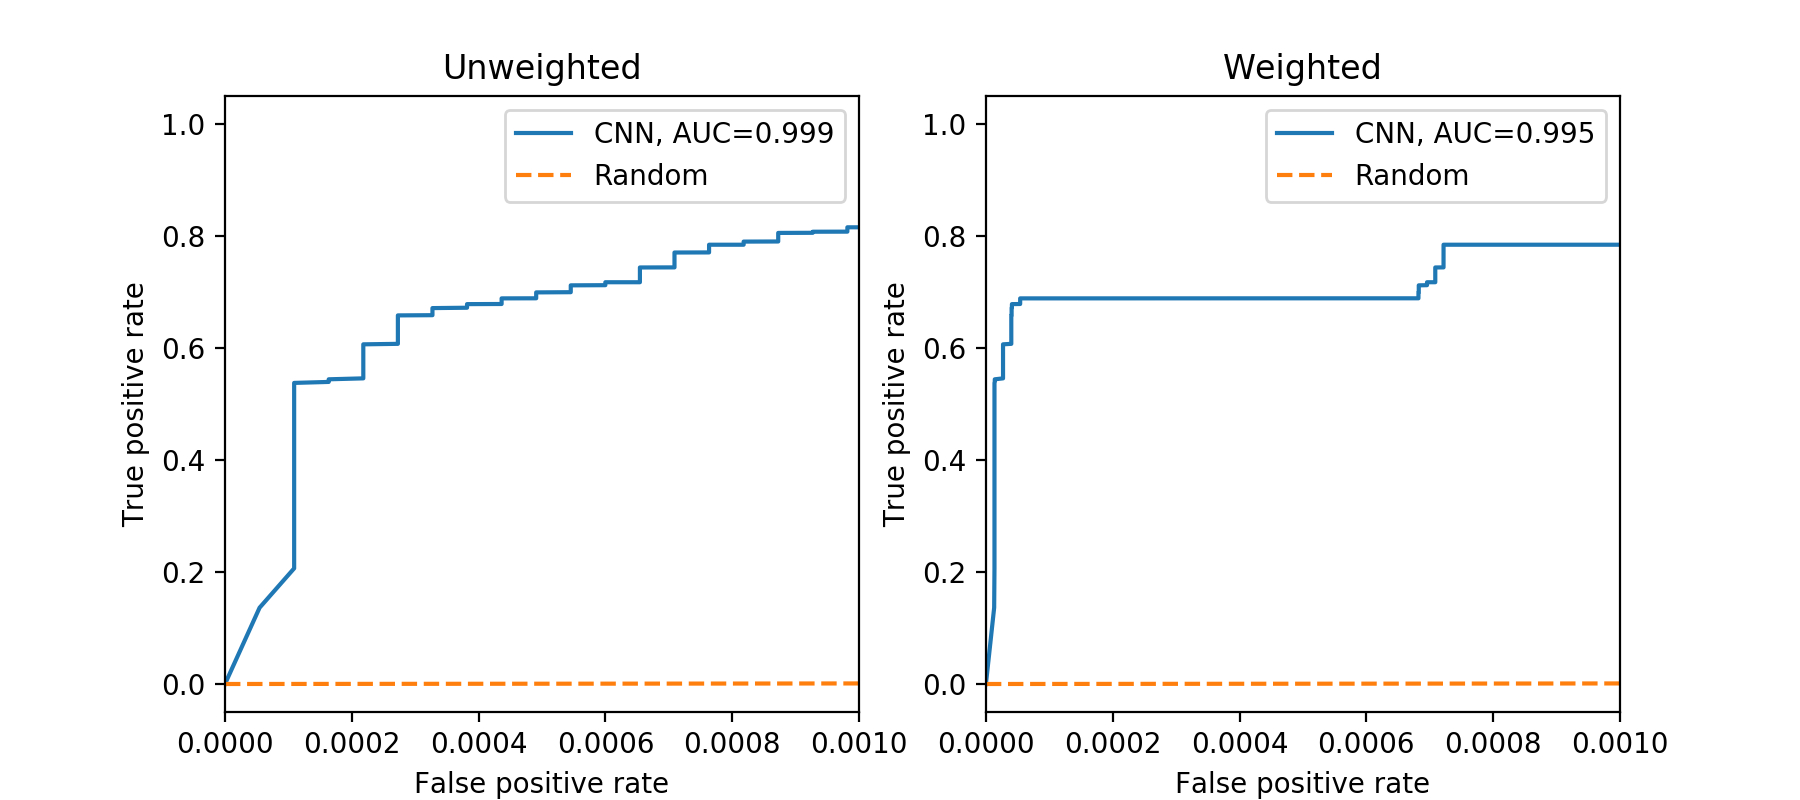

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(9,4))
draw_roc(test_labels, test_output, ax=axs[0])
draw_roc(test_labels, test_output, ax=axs[1], weights=test_weights)
axs[0].set_xlim([0, 0.001])
axs[0].set_title('Unweighted')
axs[1].set_xlim([0, 0.001])
axs[1].set_title('Weighted');

<IPython.core.display.Javascript object>


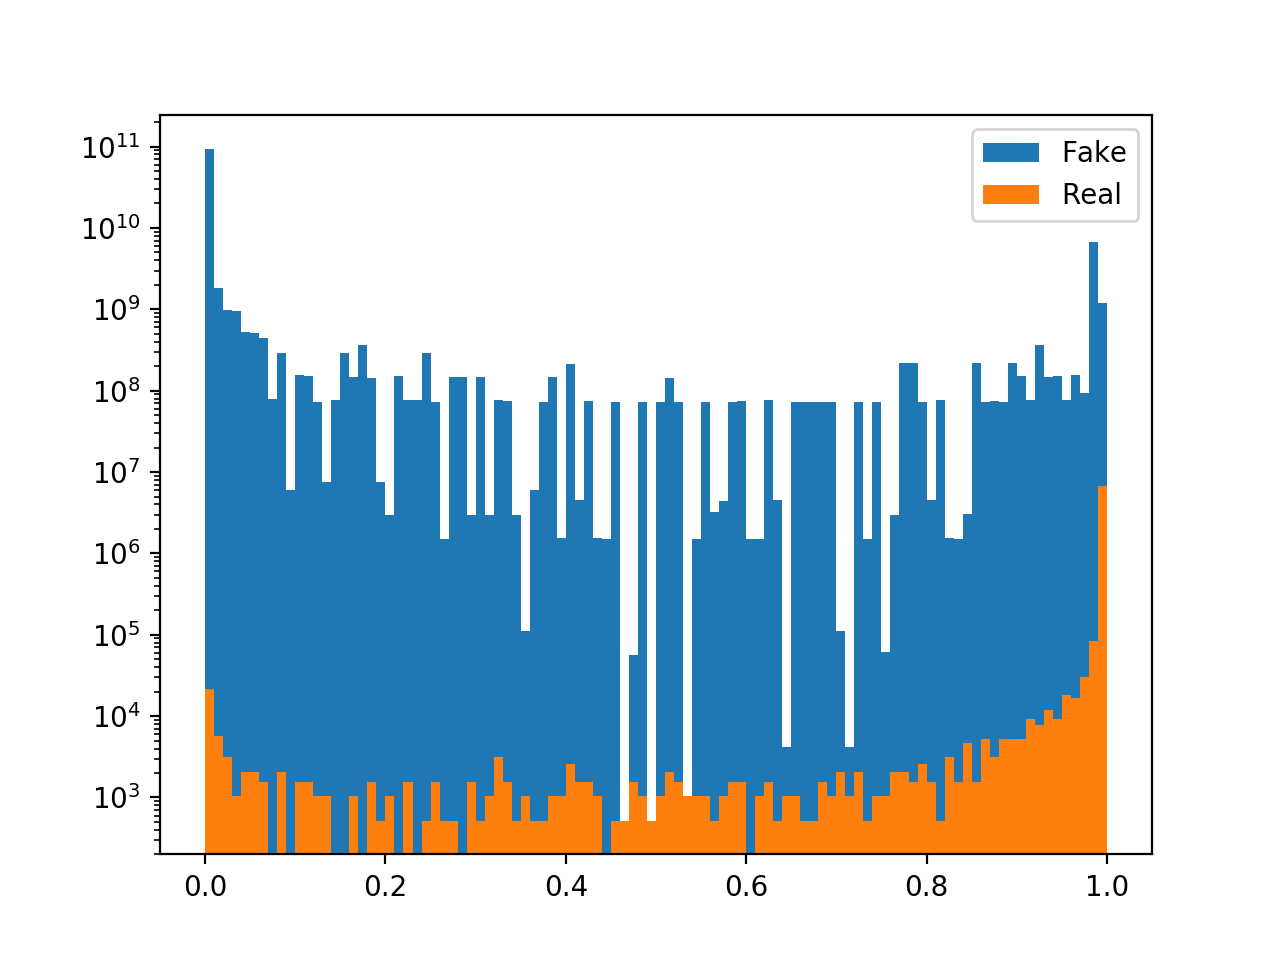

In [20]:
# Visualize the model output
plt.figure()

# Select real/fake sample model outputs
real_idx = test_labels > 0.5
fake_idx = (real_idx == False)

binning=dict(bins=100, range=(0, 1), log=True)
plt.hist(test_output[fake_idx], weights=test_weights[fake_idx], label='Fake', **binning)
plt.hist(test_output[real_idx], weights=test_weights[real_idx], label='Real', **binning)
plt.legend(loc=0);